# Test of GraphSAGE
- the version of the 40 repeat times
- use DGL
- predict `graphs`
- valid, test data are in the training dataset

In [1]:
import os
import dgl
import json
import torch
import torch as th
import dgl.nn as dglnn
# from tqdm import tqdm
from tqdm.notebook import tqdm  # 使用 notebook 版本的 tqdm
import torch.nn as nn
from dgl.nn import GraphConv, GATConv, SAGEConv
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup

- check the GPU and assign the GPU by the best memory usage

In [2]:
import subprocess
import torch

def get_free_gpu():
    try:
        # Run nvidia-smi command to get GPU details
        _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
        command = "nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader"
        memory_free_info = _output_to_list(subprocess.check_output(command.split())) 
        memory_free_values = [int(x) for i, x in enumerate(memory_free_info)]
        
        # Get the GPU with the maximum free memory
        best_gpu_id = memory_free_values.index(max(memory_free_values))
        return best_gpu_id
    except:
        # If any exception occurs, default to GPU 0 (this handles cases where nvidia-smi isn't installed)
        return 0

if torch.cuda.is_available():
    # Get the best GPU ID based on free memory and set it
    best_gpu_id = get_free_gpu()
    device = torch.device(f"cuda:{best_gpu_id}")
else:
    device = torch.device("cpu")
    print("there's no available GPU")

# device = torch.device(f"cuda:{1}")
print(device)


cuda:2


## Fix the seed

In [3]:
import numpy as np
import torch
import random

#fix seed
def same_seeds(seed = 8787):
    torch.manual_seed(seed)
    # random.seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## Data Loader

In [4]:
class GraphDataset(Dataset):
    def __init__(self, data_list, device):
        self.data_list = data_list
        self.device = device

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data = self.data_list[idx]
        return data

def collate(samples):
    data_list = samples
    batched_graphs = []
    for data in data_list:
        g = dgl.graph((th.tensor(data["edge_index"][0]), th.tensor(data["edge_index"][1])), num_nodes=data["num_nodes"])

        g.ndata['feat'] = th.tensor(data["node_feat"])
        g.edata['feat'] = th.tensor(data["edge_attr"])
        g.edata['label'] = th.tensor(data["labels"])  # Add edge labels to graph

        batched_graphs.append(g)
    
    return dgl.batch(batched_graphs)

In [30]:
datasets = ['repeat_train_40', 'valid', 'test']
# datasets = ['valid']
dataset_data = {}

for dataset_name in tqdm(datasets):
    file_path = f"../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/{dataset_name}.jsonl"
    
    print(file_path)
    with open(file_path) as f:
        data_list = [json.loads(line) for line in tqdm(f, position=0, leave=True)]
    
    dataset_data[dataset_name] = GraphDataset(data_list, device)

print("Datasets loaded!")

  0%|          | 0/3 [00:00<?, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/repeat_train_40.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/valid.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/test.jsonl


0it [00:00, ?it/s]

Datasets loaded!


- choose batch size

In [31]:
def create_dataloaders(batch_size, shuffle=True):
    dataloaders = {}
    for dataset_name, dataset in dataset_data.items():
        # do not shuffle the testing dataset
        if dataset_name == "test":
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)    
        else:
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    return dataloaders

dataloaders = create_dataloaders(16)

- Turn the print message to a log file

In [32]:
import datetime

now = datetime.datetime.now()

formatted_time = now.strftime("%m%d_%H:%M")

log_file_path = f"../log_message/{formatted_time}_GraphSAGE_transR_50.log"

def add_log_msg(msg, log_file_path=log_file_path):
    with open(log_file_path, 'a') as f:
        f.write(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}\n')
    print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}')

print(log_file_path)

../log_message/1010_19:13_GraphSAGE_transR_50.log


### Model

In [33]:
class GraphSAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GraphSAGE, self).__init__()
        self.layer1 = dglnn.SAGEConv(in_dim, hidden_dim, 'pool')
        self.layer2 = dglnn.SAGEConv(hidden_dim, out_dim, 'pool')
        self.dropout = nn.Dropout(0.25)

    def forward(self, g, inputs):
        h = self.layer1(g, inputs)
        h = torch.relu(h)
#         h = self.dropout(h)
        h = self.layer2(g, h)
        return h

In [34]:
class MLPPredictor(nn.Module):
    def __init__(self, out_feats, out_classes):
        super().__init__()
        self.W = nn.Linear(out_feats*2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [35]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_classes):
        super().__init__()
        self.sage = GraphSAGE(in_features, hidden_features, out_features)
        self.pred = MLPPredictor(out_features, num_classes)
      
    def forward(self, g, node_feat, return_logits=False):
        h = self.sage(g, node_feat)
        logits = self.pred(g, h)
        
        return logits

- Model Forward  

In [36]:
def model_fn(batched_g, model, criterion, device, count=1, which_type='train'):
    """Forward a batch through the model."""
#     batched_g, labels = data
    batched_g = batched_g.to(device)
    
    labels = batched_g.edata['label'].to(device)
    
    logits = model(batched_g, batched_g.ndata['feat'].float())

    loss = criterion(logits, labels)

    output = torch.softmax(logits, dim=1)
    preds = output.argmax(1)
    
    # Compute accuracy
    accuracy = torch.mean((preds == labels).float())
    
    if which_type == 'validation' and count % 1000 == 0:
        add_log_msg(f"labels of Validation: {labels} {labels.shape}")
        add_log_msg(f"predicted of Validation: {preds} {preds.shape}")
        
    elif which_type == 'test'  and count % 1000 == 0:
        add_log_msg(f"labels of Test: {labels} {labels.shape}")
        add_log_msg(f"predicted of Test: {preds} {preds.shape}")
        
    if count % 5000 == 0: 
        add_log_msg(f"labels of {count}: {labels} {labels.shape}")
        add_log_msg(f"predicted of {count}: {preds} {preds.shape}")
        
    return loss, accuracy, preds

### Training

- Fix the seed and save the model.state_dict that contains the initial weight

In [37]:
seed = 8787
same_seeds(seed)

model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
torch.save(model.state_dict(), 'model3_initial(graphsage)/initial_weight.pth')

In [38]:
# model.layer1.fc_self.weight
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[-0.0682,  0.0153, -0.1769,  ...,  0.0375,  0.2321, -0.2812],
        [-0.2271,  0.2290, -0.1997,  ..., -0.0095,  0.1509,  0.2686],
        [-0.2743,  0.0406, -0.1222,  ...,  0.1036, -0.1590, -0.2555],
        ...,
        [-0.0758,  0.0461,  0.1273,  ...,  0.1367,  0.0671, -0.2605],
        [-0.2425, -0.1362,  0.2474,  ..., -0.3221, -0.0595,  0.3141],
        [ 0.0234, -0.2783,  0.2146,  ..., -0.3020, -0.1751,  0.0528]],
       requires_grad=True)

- Check if model really load the model_dict

In [39]:
model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[-0.0682,  0.0153, -0.1769,  ...,  0.0375,  0.2321, -0.2812],
        [-0.2271,  0.2290, -0.1997,  ..., -0.0095,  0.1509,  0.2686],
        [-0.2743,  0.0406, -0.1222,  ...,  0.1036, -0.1590, -0.2555],
        ...,
        [-0.0758,  0.0461,  0.1273,  ...,  0.1367,  0.0671, -0.2605],
        [-0.2425, -0.1362,  0.2474,  ..., -0.3221, -0.0595,  0.3141],
        [ 0.0234, -0.2783,  0.2146,  ..., -0.3020, -0.1751,  0.0528]],
       requires_grad=True)

In [49]:
import csv
import pandas as pd
from sklearn.metrics import classification_report
from torch.optim import AdamW, lr_scheduler

seed = 5269
same_seeds(seed)

# model = GraphSAGE(in_dim=50, hidden_dim=16, out_dim=167)
model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
# in_dim means the dimension of the node_feat(50 dim, since the 50-dim embedding)
# out_dim means the # of the categories -> 168 for out tasks
model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
best_model_path = "../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50-3.pt"

model = model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-4)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=18, num_training_steps=total_steps)

# T_max control the period of the lr changing -> set 1/10 first
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0, last_epoch=- 1, verbose=False)

criterion = nn.CrossEntropyLoss()
# criterion = torch.nn.BCEWithLogitsLoss()

total_steps = 50

# save the best model
best_val_loss = float('inf')
patience = 10  # Number of epochs with no improvement after which training will be stopped.
waiting = 0  # The number of epochs with no improvement so far.


# Training Part
for epoch in tqdm(range(total_steps)):
    # Train
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0
    
    for batched_g in tqdm(dataloaders['repeat_train_40'], desc="Training", position=0, leave=True):
        num_batches += 1
        loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='train')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy.item()

    scheduler.step()
    add_log_msg(f"total batches: {num_batches}")

    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    add_log_msg(f'Epoch {epoch} | Train Loss: {avg_loss:.4f} | Train Accuracy: {avg_accuracy:.4f}')

    
    # Validation Part
    model.eval()
    total_accuracy = 0.0
    total_loss = 0.0
    num_batches = 0


    with torch.no_grad():
        for batched_g in tqdm(dataloaders['valid'], desc="Validation", position=0, leave=True):
            loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='validation')
            total_accuracy += accuracy.item()
            total_loss += loss.item()
            num_batches += 1

    avg_accuracy = total_accuracy / num_batches
    current_loss = total_loss / num_batches
    
    add_log_msg(f'Validation Loss: {current_loss:.4f} | Validation Accuracy: {avg_accuracy:.4f}\n')
    
            
    if current_loss < best_val_loss:
        best_val_loss = current_loss
        waiting = 0
        
        if os.path.exists(best_model_path):
            os.remove(best_model_path)
            add_log_msg("Find a better model!!")

        torch.save(model.state_dict(), best_model_path)

#         print(best_model_path)

    else:
        waiting += 1
        if waiting >= patience:
            add_log_msg("============================== Early stopping ==================================")
            break

  0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/10/2023, 22:14:44# labels of 5000: tensor([ 74,  97,  24,  38, 163,  75,   9, 119, 119,  42, 104, 151, 145, 145,
        145, 145, 145, 145, 124,  60,   2], device='cuda:2') torch.Size([21])
10/10/2023, 22:14:44# predicted of 5000: tensor([124,  76,  76,  76,  76,  76,  76,  76,  76,  76, 124,  76,  76,  96,
         96,  23,  23,  96,  76,  76,  76], device='cuda:2') torch.Size([21])
10/10/2023, 22:15:43# labels of 10000: tensor([  1,  18,  77,  77,  77,  77,  77,  77,  77,  77, 111,  31,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  

10/10/2023, 22:34:59# labels of 105000: tensor([ 56,  56,  56,  56,  56,  56,  60, 151, 104, 111,  36, 143,  75, 157,
        153, 153, 153, 158,  33, 125,  87, 144,  97], device='cuda:2') torch.Size([23])
10/10/2023, 22:34:59# predicted of 105000: tensor([ 56,  56,  56,  56,  56,  56,  31,  38,  55,   9,  60,  55,  42,  49,
        153, 153, 153, 119,  87, 119,  55,  42,  92], device='cuda:2') torch.Size([23])
10/10/2023, 22:36:00# labels of 110000: tensor([  4, 158, 158,  42,  44,  57,  65, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 123, 151,  47, 164,  24, 163, 158,
         76, 157,  60], device='cuda:2') torch.Size([31])
10/10/2023, 22:36:00# predicted of 110000: tensor([ 11, 164, 104,  47,  47, 119,  65, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 123,   2,  47, 119,  92, 119,  47,
         92,  92,  33], device='cuda:2') torch.Size([31])
10/10/2023, 22:36:20# total batches: 111600
10/10/2023, 22:36:20# Epoch 0 

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 22:36:20# labels of Validation: tensor([ 34,   5,   5,   5,  53,  71,  71,  71,  71,  71,  71, 129, 129, 129,
        129, 129, 129, 129,  80,  80,  80,  80,  80,  80,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16, 121, 125, 126, 126, 126,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

10/10/2023, 22:36:31# labels of Validation: tensor([153, 153, 153,  45,  65,  45,  45,  65,  46,  46,  49,  31, 162,  41,
         41,  41,  41,  41,  48, 110, 110,  11,  49,  18,  75, 113, 113, 115,
        115, 115, 115, 115, 115, 115, 115, 115, 115,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7], device='cuda:2') torch.Size([104])
10/10/2023, 22:36:31# predicted of Validation: tensor([153, 153, 153,  45,  65,  45,  45,  65,  46,  46, 125,  75,  76,  41,
         41,  41,  41,  41,  12,  18,  18,  76, 131, 104, 163,  18,  18, 115,
        115, 115, 115, 115, 115, 115, 115, 115, 115,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/10/2023, 22:37:32# labels of 5000: tensor([151, 157,   2, 144,  48,  54,  76,  36, 119,  87,  44, 144, 109,  33,
        124,  42], device='cuda:2') torch.Size([16])
10/10/2023, 22:37:32# predicted of 5000: tensor([ 81,  33,  47,  83,  55, 121,  83,  55, 121,  30, 121,  38,  60, 112,
         55, 116], device='cuda:2') torch.Size([16])
10/10/2023, 22:38:33# labels of 10000: tensor([151,  76,  49, 116, 111,  53,  87,  47,  14, 111,  47,  34, 116, 144,
        124,  44], device='cuda:2') torch.Size([16])
10/10/2023, 22:38:33# predicted of 10000: tensor([ 92,  49,  92,  92, 121,   2, 109, 158, 109,  14,  14,  14,   2, 119,
        157, 164], device='cuda:2') torch.Size([16])
10/10/2023, 22:39:34# labels of 15000: tensor([121,  44,  54, 157,  11, 157,  54, 109,   4,   2,  24, 157,  48, 163,
        151, 111], device='cuda:2') torch.Size([16])
10/10/2023, 22:39:34# predicted of 15000: tensor([125, 112,  83,  42,  60,  44,  42, 112,  97, 112, 104, 125,  42,  42,
          2, 104], device=

10/10/2023, 22:53:53# labels of 85000: tensor([  4,  53,  18,  83, 142,  83,  14,  74, 119,  76, 144,  14, 144,  83,
        163, 121], device='cuda:2') torch.Size([16])
10/10/2023, 22:53:53# predicted of 85000: tensor([111,  81, 109,   1,   1,  11,  14, 163, 162,   1,  44, 121,  14,  42,
        124,  38], device='cuda:2') torch.Size([16])
10/10/2023, 22:54:55# labels of 90000: tensor([ 87,  92,  76,  83, 151,  24, 151,  83,   4,   2,  33, 157,   8,   8,
         81,  86,  86, 104], device='cuda:2') torch.Size([18])
10/10/2023, 22:54:55# predicted of 90000: tensor([ 55, 109,   1,  42,  31, 104, 151, 142,  55, 142, 142,  92,  74, 109,
        119,  86,  86,  53], device='cuda:2') torch.Size([18])
10/10/2023, 22:55:55# labels of 95000: tensor([ 55,   4,   2, 111,  93,  93, 150, 157, 112,   4, 152,  97, 142,  12,
         76,  74, 151], device='cuda:2') torch.Size([17])
10/10/2023, 22:55:55# predicted of 95000: tensor([121,  11,  33,  83,  49, 131, 104,  34,  97, 104,  75,  49,  83, 125,

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 22:59:19# labels of Validation: tensor([ 21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  18,  75,  67,
         67,  67,  67,  67, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

10/10/2023, 22:59:30# labels of Validation: tensor([159, 159, 159, 159, 159, 159, 159, 159, 159, 159,  83,   1, 147,  65,
         65,  65,  65,  65,  65,  65,  65, 147, 147, 147, 147, 159, 159, 159,
        159, 159, 159, 159, 159, 159, 159,  48,  91,  91,  91, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/10/2023, 23:00:34# labels of 5000: tensor([ 88,  88, 121,  38,  34,  81, 119,  75,  11,  44, 140, 140, 140, 140,
        140, 140, 140, 140, 140, 140, 140, 140, 140,  54, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,  65,  65,
         65,  65, 102, 102, 144,   2, 152], device='cuda:2') torch.Size([49])
10/10/2023, 23:00:34# predicted of 5000: tensor([ 83,  83,  42,  14,   9,   4,  54,  54, 152,  18, 140, 140, 140, 140,
        140, 140, 140, 140, 140, 140, 140, 140, 140,  49, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,  65,  65,
         65,  65, 102, 102, 143,  49, 152], device='cuda:2') torch.Size([49])
10/10/2023, 23:01:35# labels of 10000: tensor([ 24, 144,  47, 117, 117, 117,  33,  12, 109, 108, 108, 108, 108,  12,
        130, 130, 130, 130, 130,  76,  81,  42, 119, 104, 152],
       device='cuda:2') torch.Size([25])
10/10/2023, 23:01:35# predicted of 10000: tensor([ 11,  33,  47, 117, 117, 

10/10/2023, 23:22:01# labels of 110000: tensor([125,  30, 116, 116,  24,  87,  11, 109,  74,  18, 109,   2,   4,  60,
        162,   2], device='cuda:2') torch.Size([16])
10/10/2023, 23:22:01# predicted of 110000: tensor([109, 119,  57, 104,  31,  75, 143, 119, 151,  57,  83,   1,  14, 142,
        163,  44], device='cuda:2') torch.Size([16])
10/10/2023, 23:22:20# total batches: 111600
10/10/2023, 23:22:20# Epoch 2 | Train Loss: 2.9627 | Train Accuracy: 0.2736


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 23:22:20# labels of Validation: tensor([146, 146, 146, 146, 146, 146,  67,  67,  67,  67,  67, 140, 140, 140,
        140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 113, 113,   5,   5,
          5,  18,   1, 100, 100, 100, 100, 100, 100,  81,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  13,  13,  13,  13,  13,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65, 135, 135,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  12, 104,  80,  80,  80,  80,  80,  80], device='cuda:2') torch.Size([150])
10/10/2023, 23:22:20# predicted of Validation: tensor([146, 146, 146, 146, 146, 14

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/10/2023, 23:23:33# labels of 5000: tensor([ 57,  38,  11,   4,   9,  55,  18, 152,  53, 143, 163, 121,  53,  49,
         55,  75], device='cuda:2') torch.Size([16])
10/10/2023, 23:23:33# predicted of 5000: tensor([ 55,  81, 143, 158,  31,  11,  18,  36,  44,  11, 112,  38,  75,  74,
         74, 152], device='cuda:2') torch.Size([16])
10/10/2023, 23:24:34# labels of 10000: tensor([163,  81, 144, 143,  47, 157, 150, 109,  81, 120, 120, 120, 120, 120,
        120,   4,  83,  54,  44,  60,  75], device='cuda:2') torch.Size([21])
10/10/2023, 23:24:34# predicted of 10000: tensor([162,  74, 112,  55,  83, 164,  92,  55, 119, 120, 120, 120, 120, 120,
        120,  83,  18,  33,  42,  76,  33], device='cuda:2') torch.Size([21])
10/10/2023, 23:25:35# labels of 15000: tensor([152,  47,  81, 152, 109, 150, 104, 119,  57,  11,  42,  92,  54,  57,
         33,  18], device='cuda:2') torch.Size([16])
10/10/2023, 23:25:35# predicted of 15000: tensor([ 42, 164,   9, 142, 109,  34, 119, 119,  57,  

10/10/2023, 23:42:00# labels of 95000: tensor([ 92,  36, 121,  76,  81,  55,  83,  49,  31, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 162,   4,  76, 144, 163,  11], device='cuda:2') torch.Size([35])
10/10/2023, 23:42:00# predicted of 95000: tensor([ 38, 158, 121,  76,  87, 157,  49,  18,  12, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127,  18,  76,  14,  60, 121, 124], device='cuda:2') torch.Size([35])
10/10/2023, 23:43:00# labels of 100000: tensor([119,  14, 158, 162, 157, 152,  92,  30,  11, 121, 125,  57, 111,  42,
        143, 142], device='cuda:2') torch.Size([16])
10/10/2023, 23:43:00# predicted of 100000: tensor([ 92, 121,  53,  81,  34,  57,  87, 109,  83,  75, 162,  74,  76,  14,
        150,  34], device='cuda:2') torch.Size([16])
10/10/2023, 23:44:00# labels of 105000: tensor([142,  55,  49,  18,  76, 104,  11,  49,  11,  74,  83, 163

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/10/2023, 23:45:21# labels of Validation: tensor([ 60,  55, 100, 100, 100, 100, 100, 100,  73,  73,  73, 147,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 147, 147, 147, 147,
         28,  28,  28,  28,  28,  65,  28,  28,  28,  28,  28,  28,  28,  90,
         90,  69,  69,  69,  69,  69,  69, 104,  60, 130, 130, 130, 130, 130,
         86,  86,  35,  35,  35,  35,  35,  35,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  5

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/10/2023, 23:46:34# labels of 5000: tensor([  2,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  18,  11, 164, 163, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 112,  97,  38,  31,  97,  18, 150, 109,  32,  32,  32,
         32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32],
       device='cuda:2') torch.Size([68])
10/10/2023, 23:46:34# predicted of 5000: tensor([ 11,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,   1,  11,  76,  47, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 163, 142,  34,  31, 111, 164, 163, 119,  32,  32,  32,
         32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32],
       device='cuda:2') torch.Size([68])
10/10/2023, 23:47:36# labels of 10000: tensor([150,  83,  91,  91,  91,  81, 

10/11/2023, 00:05:20# labels of 95000: tensor([ 55,  74,  36,   4, 158,  30,  75, 164,  74,  12, 162,  14,  60, 125,
        162, 116], device='cuda:2') torch.Size([16])
10/11/2023, 00:05:20# predicted of 95000: tensor([ 55,  14,  42,  42, 104,  74,  81, 164, 121,  53,  42,  53,  83, 116,
         34,  47], device='cuda:2') torch.Size([16])
10/11/2023, 00:06:30# labels of 100000: tensor([ 31,  96,  96,  96,  96,  96,  96, 157, 162,  74,  97, 116, 162,  11,
         31,  30, 143,  97, 151, 144,  48], device='cuda:2') torch.Size([21])
10/11/2023, 00:06:30# predicted of 100000: tensor([ 34,  96,  96,  96,  96,  96,  96, 152, 162, 164,  48, 116,  75,  81,
        164,  83,  81,  54,  76,   4, 112], device='cuda:2') torch.Size([21])
10/11/2023, 00:07:37# labels of 105000: tensor([  1,  57,   1, 150, 163,  83,  38,  55,  81,  48,  44, 104, 151, 158,
         42,   1], device='cuda:2') torch.Size([16])
10/11/2023, 00:07:37# predicted of 105000: tensor([ 31,   2, 158,  34,   9,  83, 112,  18, 

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 00:09:09# labels of Validation: tensor([143,  18,  96,  96,  96,  96,  96,  96,  47,  14,  65,  65,  65,  65,
         65,  65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70, 110, 110,   1,
          0,   0,   0,   0,   0,   0, 124,  64,  64, 130, 130, 130, 130, 130,
         65,  65,  65,  65,  65,  65, 141, 141, 141, 141, 141, 141, 141, 141,
        141, 141,  55, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        105, 105,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21],
       device='cuda:2') torch.Size([97])
10/11/2023, 00:09:09# predicted of Validation: tensor([116,  83,  96,  96,  96,  96,  96,  96, 119,  83,  65,  65,  65,  65,
         65,  65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  49,  60,  42,
          0,   0,   0,   0,   0,   0,  11,  74,  74, 130, 130, 130, 130, 130,
         65,  

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/11/2023, 00:10:30# labels of 5000: tensor([ 14, 151,  48,  12, 164,  49,  53, 157,  30, 124,  75,  92,  49,  75,
        109,   2], device='cuda:2') torch.Size([16])
10/11/2023, 00:10:30# predicted of 5000: tensor([ 31, 162, 116,   9,  14,  33, 142,  38,  81, 112,  42, 109,  47,  75,
         83,  87], device='cuda:2') torch.Size([16])
10/11/2023, 00:11:42# labels of 10000: tensor([144, 144, 119, 163,  55,  34, 163, 158, 119,  81, 158, 164,  47, 163,
        164, 144], device='cuda:2') torch.Size([16])
10/11/2023, 00:11:42# predicted of 10000: tensor([143, 121,  34,  60, 157, 125, 109,  55, 150,  60, 119,  18,  47,  47,
         49,  55], device='cuda:2') torch.Size([16])
10/11/2023, 00:12:52# labels of 15000: tensor([  2, 119, 109, 143,  14,  12,  20,  20, 143,  36,  12,  54,  57,  44,
         83,  60, 112], device='cuda:2') torch.Size([17])
10/11/2023, 00:12:52# predicted of 15000: tensor([ 81, 119,  57, 112, 124,  18,  20,  20,  18,  47, 164,  42, 157, 142,
         11,  87,  76

10/11/2023, 00:32:29# labels of 100000: tensor([ 54,  53, 142,  54,  47,  11,  31, 104, 152,  76, 150,  55, 104, 121,
          1,  33], device='cuda:2') torch.Size([16])
10/11/2023, 00:32:29# predicted of 100000: tensor([ 83, 158, 116, 164,  74,  24,  31, 109, 112,  54,  55,  75,  34,  55,
         60,  76], device='cuda:2') torch.Size([16])
10/11/2023, 00:33:38# labels of 105000: tensor([ 42,  18, 109, 124,  36,  42,  31,  11,  18, 162, 152, 116, 112,  47,
        121, 111], device='cuda:2') torch.Size([16])
10/11/2023, 00:33:38# predicted of 105000: tensor([ 42,  11,  18, 119, 164,  14,  81, 150, 109, 164, 150,  53, 142, 109,
         55,   1], device='cuda:2') torch.Size([16])
10/11/2023, 00:34:43# labels of 110000: tensor([ 18,  36,  83, 151,  54, 150,  48,   9, 121, 142,  34,  47, 143,  97,
         11,  34], device='cuda:2') torch.Size([16])
10/11/2023, 00:34:43# predicted of 110000: tensor([104,  12, 158, 125,  83, 109,  87,   1,  60,  54,  31,  83, 116,  54,
        124,  74],

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 00:35:03# labels of Validation: tensor([161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161,  61,  61,  61, 158,
        137, 137, 137, 137, 137,  28,  28,  28,  28,  28,  65,  28,  28,  28,
         28,  28,  2

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/11/2023, 00:36:21# labels of 5000: tensor([ 60,  42,  14,   9, 142,  55,   2, 124,  74,  33, 116, 111,  57, 124,
         48,   2], device='cuda:2') torch.Size([16])
10/11/2023, 00:36:21# predicted of 5000: tensor([116,  31,  87,   1,  74,  83, 142, 124,  60,  42, 125,  18, 109,  47,
          1, 112], device='cuda:2') torch.Size([16])
10/11/2023, 00:37:24# labels of 10000: tensor([121,  92,  87,   1,  87, 125,  48,  42, 121, 164, 116, 121,   4,  24,
         36,  12], device='cuda:2') torch.Size([16])
10/11/2023, 00:37:24# predicted of 10000: tensor([ 33,  31,  76,  83, 163,  11,  18,  42,  81, 163,  48, 158,  14, 116,
         14, 144], device='cuda:2') torch.Size([16])
10/11/2023, 00:38:29# labels of 15000: tensor([ 31,  12, 163,   9,  49,  48,  34,  76, 109, 164,  48, 112, 116, 121,
         96,  96,  96,  96,  96,  96,  42], device='cuda:2') torch.Size([21])
10/11/2023, 00:38:29# predicted of 15000: tensor([ 76,  92, 163, 142,  57,  18,  75,  75,  54,   1,  74, 124,  47, 150,
 

10/11/2023, 00:55:26# labels of 95000: tensor([  2, 163,  44, 104, 121,  54, 163, 157, 130, 130, 130, 130, 130,  11,
         81,  60,  11,  18, 144,  48], device='cuda:2') torch.Size([20])
10/11/2023, 00:55:26# predicted of 95000: tensor([164,  34,   4, 152,  24,   1, 163, 116, 130, 130, 130, 130, 130,  31,
         53, 152,   1,  49, 112,  24], device='cuda:2') torch.Size([20])
10/11/2023, 00:56:28# labels of 100000: tensor([158,  30,  81,  48, 143,  31,  75, 125,  14,  53, 111, 142,  47,  31,
         12,  55], device='cuda:2') torch.Size([16])
10/11/2023, 00:56:28# predicted of 100000: tensor([124,   2,  55,  76,  53,  54,  18, 142,  42, 163,  83,  49,  47, 119,
        104,  11], device='cuda:2') torch.Size([16])
10/11/2023, 00:57:29# labels of 105000: tensor([ 42,  87,  54,  42,  33, 142, 124,  53, 162, 112,  81,  83,  31,   9,
         81,   1], device='cuda:2') torch.Size([16])
10/11/2023, 00:57:29# predicted of 105000: tensor([ 55,  47, 125,  12,  36, 104,  36,  92,  55, 150, 

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 00:58:51# labels of Validation: tensor([125,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  87,  50,  50,  50,   2,  27,  27,
         27,  91,  91,  91,   0,   0,   0,   0,   0,   0, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 110, 110,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  98,  45,  65,
         45,  45, 14

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/11/2023, 01:00:05# labels of 5000: tensor([124, 150,  36,  48,  34, 121, 150,  36, 116,  31, 119, 109, 142,  11,
         18,  12], device='cuda:2') torch.Size([16])
10/11/2023, 01:00:05# predicted of 5000: tensor([ 53,   2, 143,  33,  55,  74,  31,  81,  74,   1,  11,  34, 142,  54,
         18,  74], device='cuda:2') torch.Size([16])
10/11/2023, 01:01:07# labels of 10000: tensor([ 83, 151, 119,  64,  64,   4,   4,  75,  48,  44,  75, 112,  47,  24,
        121,  47,   4], device='cuda:2') torch.Size([17])
10/11/2023, 01:01:07# predicted of 10000: tensor([121,   1,  31, 121, 121,  92,   4,  33,  30, 109,  54,  44,  31,  24,
         83,  54, 157], device='cuda:2') torch.Size([17])
10/11/2023, 01:02:08# labels of 15000: tensor([ 34, 125,  42,  30,  83,  44,  75, 116,   4,   9, 119, 116,  87,  75,
         92,  54], device='cuda:2') torch.Size([16])
10/11/2023, 01:02:08# predicted of 15000: tensor([ 74,  53,  53,  81,  83,  24, 152,  49,  18,  81,  38,  18,  31, 104,
        152, 116

10/11/2023, 01:15:30# labels of 80000: tensor([  9,  47,  60,  97, 150,   4,  76, 119,  74,  31, 150,  42,  33,  11,
          2,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
         32,  32], device='cuda:2') torch.Size([30])
10/11/2023, 01:15:30# predicted of 80000: tensor([121,  31,  49,  44, 121,   1,  76,  83,  74,  11, 121,  47,  12,  44,
         81,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
         32,  32], device='cuda:2') torch.Size([30])
10/11/2023, 01:16:31# labels of 85000: tensor([ 30, 142,  87,  11, 144,  53,  83, 125,  81, 157,  33, 143,  18, 162,
         14,  57], device='cuda:2') torch.Size([16])
10/11/2023, 01:16:31# predicted of 85000: tensor([ 31, 124,   4,  42,  38,  87,   4, 152,  44, 163, 104,  47, 157,  31,
         81,  92], device='cuda:2') torch.Size([16])
10/11/2023, 01:17:31# labels of 90000: tensor([ 87,  54, 162,  24, 144, 144, 125,  92,  42, 109,   1, 125,  14,   4,
         31,  87], device='cuda:2') torch

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 01:21:57# labels of Validation: tensor([128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128,  12, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,  53,
        126, 126, 126,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         65,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  5

10/11/2023, 01:22:10# labels of Validation: tensor([165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,  69,  69,
         69,  69,  69,  69,  14,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  65,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  5

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/11/2023, 01:23:12# labels of 5000: tensor([ 76,  42,  31,  14,  14, 124,  11,  44,  44, 112, 164,   9,  74, 144,
        164,  33], device='cuda:2') torch.Size([16])
10/11/2023, 01:23:12# predicted of 5000: tensor([ 76, 119,  31,   9,  24, 124, 112, 104, 112,  31,  49,  47,  57,  81,
         31,  12], device='cuda:2') torch.Size([16])
10/11/2023, 01:24:14# labels of 10000: tensor([ 33, 109,   4,   4,  92,  11, 151,  49,  81, 142, 112, 124,  97, 124,
          2,  60], device='cuda:2') torch.Size([16])
10/11/2023, 01:24:14# predicted of 10000: tensor([116,  49,  87, 124, 151,  57,  92,  60, 124,  47, 109, 116,  97,  57,
         44,  75], device='cuda:2') torch.Size([16])
10/11/2023, 01:25:16# labels of 15000: tensor([ 53,  76,  11,  33,  43,  43,  12,  42,  36, 125,  49,  97,  81,  53,
         38, 109,  75], device='cuda:2') torch.Size([17])
10/11/2023, 01:25:16# predicted of 15000: tensor([ 12,  76, 142,  74,  43,  43,  48,  42,  42, 125,  30, 125,  74,  55,
         12, 164,   1

10/11/2023, 01:41:41# labels of 95000: tensor([119,  47, 112, 119,  49, 164, 125,  24, 107, 107, 107, 107, 107, 107,
        107, 107,  97, 104,  34,  14, 124,  53,  12], device='cuda:2') torch.Size([23])
10/11/2023, 01:41:41# predicted of 95000: tensor([ 74, 157,   1, 150,  76,  83,  34,  87, 107, 107, 107, 107, 107, 107,
        107, 107,  74, 143, 143,  55,  83,  33, 143], device='cuda:2') torch.Size([23])
10/11/2023, 01:42:42# labels of 100000: tensor([ 24, 112,  74, 125, 116,  31,  45,  45,  45, 109, 121, 109,   4, 164,
        119, 148, 148, 148, 148, 148, 148, 148,   9, 158], device='cuda:2') torch.Size([24])
10/11/2023, 01:42:42# predicted of 100000: tensor([ 81,  14,   4,  76, 119,  18,  45,  45,  45, 142, 164, 119, 142,   2,
        119, 148, 148, 148, 148, 148, 148, 148,   2, 164], device='cuda:2') torch.Size([24])
10/11/2023, 01:43:44# labels of 105000: tensor([124,   5,   5,   5,   2, 164,  97,  60,  14,   2,   2,  12,  94,  94,
         92,  34,  11, 143,  47], device='cu

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 01:45:04# labels of Validation: tensor([ 52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  65,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  65,  65,
         65,  65,  65,  65, 135, 135,  61,  61,  61, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 16

10/11/2023, 01:45:16# labels of Validation: tensor([ 96,  96,  96,  96,  96,  96,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,  28,  28,  28,  28,  28,  28,  28,
         28,  28,  28,  28,  28, 103, 103, 136, 136, 136, 136, 136, 136, 136,
         37,  37,  37,  37,  37, 150,  89,  89,  18,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 141, 141, 141,
        141, 141, 14

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/11/2023, 01:46:18# labels of 5000: tensor([150,  14,  60,  31,   9,  13,  13,  13,  13,  13,  44,   2,  87,  47,
        121,  75, 121,   2, 125, 142], device='cuda:2') torch.Size([20])
10/11/2023, 01:46:18# predicted of 5000: tensor([119,  48,  24,  87,   1,  13,  13,  13,  13,  13, 119,  83,  87, 150,
        121,  74, 124,  36,  49, 109], device='cuda:2') torch.Size([20])
10/11/2023, 01:47:18# labels of 10000: tensor([ 18, 144, 157, 143,  36, 164,  34,  34,  14,  97, 151,  24,   4,  92,
         36,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3], device='cuda:2') torch.Size([30])
10/11/2023, 01:47:18# predicted of 10000: tensor([ 54,  14, 124,  60, 157,  42,  48,  14, 109,  83,  55,  81,  47,  92,
         75,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3], device='cuda:2') torch.Size([30])
10/11/2023, 01:48:20# labels of 15000: tensor([164, 152,  38,  94,  94,  14, 136, 136, 136, 136, 136, 136, 136,  87,
   

10/11/2023, 02:06:45# labels of 105000: tensor([  9, 119,  36, 119, 152,  81,   1, 143,  57, 124,  60,  14,  33,  60,
         83,  30], device='cuda:2') torch.Size([16])
10/11/2023, 02:06:45# predicted of 105000: tensor([124, 119, 164, 164,  47, 125,  87,  18,  92,  48,  18,  87, 163,  48,
         53,  34], device='cuda:2') torch.Size([16])
10/11/2023, 02:07:46# labels of 110000: tensor([ 76,  18, 151,  92,  55,  30,  33, 119,  62,  62,  62,  62,  62,  62,
        150,  42,  44,  11, 119,  55,  53], device='cuda:2') torch.Size([21])
10/11/2023, 02:07:46# predicted of 110000: tensor([ 97,  74, 119,  92,  97,  81, 157, 119,  62,  62,  62,  62,  62,  62,
         47,   1, 104,  74, 158,  76,  33], device='cuda:2') torch.Size([21])
10/11/2023, 02:08:07# total batches: 111600
10/11/2023, 02:08:07# Epoch 9 | Train Loss: 2.8900 | Train Accuracy: 0.2881


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 02:08:07# labels of Validation: tensor([ 29,  29,  29,  29,  29,  29,  29,  29,  29,  29, 120, 120, 120, 120,
        120, 120, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        105, 150, 151,  88,  88,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,  72,  72,  33,  50,  50,  50,  13,  13,  13,  13,  13, 102,
        102, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/11/2023, 02:08:19# Validation Loss: 0.2916 | Validation Accuracy: 0.9350



Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/11/2023, 02:09:20# labels of 5000: tensor([ 37,  37,  37,  37,  37, 152, 163,  14, 104,  92,  74, 162,  47, 121,
         30,   1, 104,  18,  75, 164], device='cuda:2') torch.Size([20])
10/11/2023, 02:09:20# predicted of 5000: tensor([ 37,  37,  37,  37,  37, 152,  55, 162,   2, 163, 112,  81, 125,   2,
        151,  24,  31, 164,  75, 164], device='cuda:2') torch.Size([20])
10/11/2023, 02:10:21# labels of 10000: tensor([ 74,   2,  42,  55,  38, 164,  24,  38, 157,  75,  92, 121,  81,  14,
         31,  34], device='cuda:2') torch.Size([16])
10/11/2023, 02:10:21# predicted of 10000: tensor([116, 109, 125, 124, 158,  33,  44,  24,  47, 111,  11, 121, 124, 121,
        142,  34], device='cuda:2') torch.Size([16])
10/11/2023, 02:11:23# labels of 15000: tensor([143,   1,   2, 112,  60, 143, 112,  42,  11,  47,  11, 150,  92, 158,
        158,  83], device='cuda:2') torch.Size([16])
10/11/2023, 02:11:23# predicted of 15000: tensor([ 76,  53, 152,  12,   1, 125, 125,  31, 104,  47,  11,  

10/11/2023, 02:31:11# total batches: 111600
10/11/2023, 02:31:11# Epoch 10 | Train Loss: 2.8762 | Train Accuracy: 0.2910


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 02:31:11# labels of Validation: tensor([ 50,  50,  50, 150, 146, 146, 146, 146, 146, 146,  59,  59,  59, 129,
        129, 129, 129, 129, 129, 129,  76, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 163,   5,   5,   5, 158,  53, 158,  11,   4,
         80,  80,  80,  80,  80,  80,  91,  91,  91], device='cuda:2') torch.Size([121])
10/11/2023, 02:31:11# predicted of Validation: tensor([ 50,  50,  50,   1, 146, 146, 146, 146, 146, 146,  81,  81,  81, 129,
        129, 129, 129, 129, 129, 129,  60, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 16

10/11/2023, 02:31:23# Validation Loss: 0.2998 | Validation Accuracy: 0.9335



Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/11/2023, 02:32:27# labels of 5000: tensor([109,  14,  11,  30,  55, 121,   9,  55,  14,  34,  30, 163,  18,   9,
         54,  49], device='cuda:2') torch.Size([16])
10/11/2023, 02:32:27# predicted of 5000: tensor([ 31,  83, 119, 162,  75,  83, 112, 158,  14,   1,  75,  57, 119,  30,
         31,  49], device='cuda:2') torch.Size([16])
10/11/2023, 02:33:28# labels of 10000: tensor([112,  55,  14,  18, 142, 125,  54,  12,  36,  49, 142,  89,  89,  81,
        164, 163, 151], device='cuda:2') torch.Size([17])
10/11/2023, 02:33:28# predicted of 10000: tensor([  4,  14,  12,  49,  24,  74,   4,  92,  24,  14, 164,  89,  89, 124,
         74, 116,  14], device='cuda:2') torch.Size([17])
10/11/2023, 02:34:31# labels of 15000: tensor([116,   2,  44,  57,  38, 124, 109,  18,  36,  95,  95,  95, 150, 119,
         23,  23,  23,  23,  23, 125, 121, 121], device='cuda:2') torch.Size([22])
10/11/2023, 02:34:31# predicted of 15000: tensor([119,  75,  83, 119,  38, 151,  76,  14,  75,  95,  95,  

10/11/2023, 02:49:55# labels of 90000: tensor([158, 112,  31,  24,  36, 162, 110, 110,   4, 150,  92,  33, 150,  74,
        109,  30, 158], device='cuda:2') torch.Size([17])
10/11/2023, 02:49:55# predicted of 90000: tensor([119,  11,  31, 121,  24,  81,  24,  24,  54,  42,  12, 112,  54, 116,
         31,  31, 109], device='cuda:2') torch.Size([17])
10/11/2023, 02:50:56# labels of 95000: tensor([ 74,  76, 162, 111, 151,  18,  12,  74,  68,  68,  92, 111,  92,  34,
        164, 152, 144], device='cuda:2') torch.Size([17])
10/11/2023, 02:50:56# predicted of 95000: tensor([121,  47,  54,  87, 164,  18,   1, 116,  53,  53,  87, 163,  92, 104,
         87, 164,  14], device='cuda:2') torch.Size([17])
10/11/2023, 02:51:57# labels of 100000: tensor([125,   1,  47,   9, 125, 157,  34,  92, 119,  33,  92,  42,  31, 158,
         48, 111], device='cuda:2') torch.Size([16])
10/11/2023, 02:51:57# predicted of 100000: tensor([  4, 121,   1,  34, 142,  76, 142,  92, 119, 143,  92,  53,  55, 164,
  

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 02:54:20# labels of Validation: tensor([ 95,  95,  95,  60,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/11/2023, 02:54:31# labels of Validation: tensor([151, 147,  65, 147, 147, 147, 147, 145, 145, 145, 145, 145, 145,  14,
         34,  37,  37,  37,  37,  37,  41,  41,  41,  41,  41,  63,  63,  63,
         63,  90,  90, 111,  86,  86, 100, 100, 100, 100, 100, 100,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/11/2023, 02:55:34# labels of 5000: tensor([151, 162,  54,  18,   2,  11, 151,  31, 164,  42,  81,  36, 164,  75,
          1,  38], device='cuda:2') torch.Size([16])
10/11/2023, 02:55:34# predicted of 5000: tensor([121, 124,   4, 119,  33,  75,  38,  76,  12,  42,  92,   4, 109, 143,
         34,  14], device='cuda:2') torch.Size([16])
10/11/2023, 02:56:37# labels of 10000: tensor([158,  49,  84,  84,  84,  84,  84,  84,  84,  84,  84,  87,  48, 111,
        152,   1, 157,  53, 116,  53, 121, 111,  55,  31], device='cuda:2') torch.Size([24])
10/11/2023, 02:56:37# predicted of 10000: tensor([  4, 158,  84,  84,  84,  84,  84,  84,  84,  84,  84, 164, 119, 164,
        151,  34,  75,  60, 116,  57,  76,  34,  76,  55], device='cuda:2') torch.Size([24])
10/11/2023, 02:57:39# labels of 15000: tensor([113, 113, 125,  75,   1,   1, 152, 125,  61,  61,  61,  57,  47,  24,
        119,  76,  24, 162,  87], device='cuda:2') torch.Size([19])
10/11/2023, 02:57:39# predicted of 15000: tensor([ 

10/11/2023, 03:10:55# labels of 80000: tensor([  9,  53,  55,  75,  42,  47, 109,  26,  26,  26,  26,  26,  26, 121,
         57, 111,  50,  50,  50,  44,  18,  30,  85,  85,  85,  85,  85,  85,
         85,  85,  85,  85,  85], device='cuda:2') torch.Size([33])
10/11/2023, 03:10:55# predicted of 80000: tensor([ 76, 143,  76,  12, 121,  53, 144,  26,  26,  26,  26,  26,  26,  42,
         18,  74,  50,  50,  50, 150,  38,  30,  85,  85,  85,  85,  85,  85,
         85,  85,  85,  85,  85], device='cuda:2') torch.Size([33])
10/11/2023, 03:11:57# labels of 85000: tensor([ 33,  48, 112, 116, 124,  54, 119,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25, 116,  42,  12, 125,  47,  53,  86,  86,  48], device='cuda:2') torch.Size([66])
10/11/2023, 03:11:57# predi

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 03:17:27# labels of Validation: tensor([ 78,  78,  78,  78,  78, 136, 136, 136, 136, 136, 136, 136,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  65,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99, 157, 107, 107, 107, 107, 107, 107,
        107, 107, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        146, 146, 146, 146, 146, 146, 111, 124, 111, 126, 126, 126, 130, 130,
        130, 130, 130,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         65,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  5

10/11/2023, 03:17:38# labels of Validation: tensor([129, 129, 129, 129, 129, 129, 129,  54, 145, 145, 145, 145, 145, 145,
         34,  80,  80,  80,  80,  80,  80, 125,  38, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 16

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/11/2023, 03:18:40# labels of 5000: tensor([ 53, 112,  11,  34,  34,  49, 121, 104,  33, 164, 142,  42, 104, 111,
         48, 109], device='cuda:2') torch.Size([16])
10/11/2023, 03:18:40# predicted of 5000: tensor([116, 119, 104,  55,  49,  55,  74, 104,  53,  55,  49,  42, 143,  75,
         87,  34], device='cuda:2') torch.Size([16])
10/11/2023, 03:19:41# labels of 10000: tensor([152, 111,  83, 116, 144,  54,  60, 142,  11, 124, 157, 157,  81,  48,
        111, 121], device='cuda:2') torch.Size([16])
10/11/2023, 03:19:41# predicted of 10000: tensor([144,  34, 104, 116,  47, 158, 116, 143,  14,   9,  92,  14,  92,  48,
         76,  38], device='cuda:2') torch.Size([16])
10/11/2023, 03:20:43# labels of 15000: tensor([144,  36, 163,  33, 112, 152, 144,  11,  31,  74,  91,  91,  91,  74,
         97,  48,  36, 125], device='cuda:2') torch.Size([18])
10/11/2023, 03:20:43# predicted of 15000: tensor([ 57, 162,  34,  34,   1,  83,  34,  42, 142,  54, 131, 108, 162, 144,
        119,  54

10/11/2023, 03:31:55# labels of 70000: tensor([ 57,  57,  11,  97,   9, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156,  65,  65,  65,  65, 156, 156, 156, 156, 156,
        156, 156, 156,  33, 157,  38,  55,  38, 112,  24, 157,  75,  34],
       device='cuda:2') torch.Size([83])
10/11/2023, 03:31:55# predicted of 70000: tensor([104,  14, 152,  36,   9, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156,  65,  65,  65,  65, 156, 156, 156, 156, 156,
        156, 156, 156,  

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 03:40:27# labels of Validation: tensor([125, 163, 108, 108, 108, 108, 100, 100, 100, 100, 100, 100, 107, 107,
        107, 107, 107, 107, 107, 107,  24, 163, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 140, 140, 140, 140,
        140, 140, 140, 140, 140, 140, 140, 140, 140,  29,  29,  29,  29,  29,
         29,  29,  29,  29,  29, 163,  21,  21,  21,  21,  21,  21,  21,  21,
         21,  21,  21, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165,  67,  67,  67,  67,  67,  85,  85,  85,  85,  85,  85,  85,  85,
         85,  85,  8

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/11/2023, 03:41:41# labels of 5000: tensor([ 34,  34,  18, 142,   2,  87, 157, 142, 163,  11,  53,  60,  92,  18,
         60,   1], device='cuda:2') torch.Size([16])
10/11/2023, 03:41:41# predicted of 5000: tensor([104,  49,  18, 164,  38,  92, 157, 143, 163,   1, 125,  12,  92,  18,
         42,  74], device='cuda:2') torch.Size([16])
10/11/2023, 03:42:41# labels of 10000: tensor([165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 120, 120,
        120, 120, 120, 120, 119, 158, 116,  31, 116,   2, 157, 142,   9,   2,
         74,  55, 151, 162], device='cuda:2') torch.Size([102])
10/11/2023

10/11/2023, 04:01:11# labels of 100000: tensor([ 48, 104, 119, 157,  11,  11,  67,  67,  67,  67,  67,  18, 164, 116,
         83,  36, 142,  11,  30,  83], device='cuda:2') torch.Size([20])
10/11/2023, 04:01:11# predicted of 100000: tensor([ 54,  53, 109,  47, 162,  49,  67,  67,  67,  67,  67, 158, 150, 112,
         36,   4, 109,  47, 163,  11], device='cuda:2') torch.Size([20])
10/11/2023, 04:02:12# labels of 105000: tensor([ 31, 158, 151,  11,  75,  87,  48, 162, 151, 119, 152, 145, 145, 145,
        145, 145, 145,  81,  33, 125,  49], device='cuda:2') torch.Size([21])
10/11/2023, 04:02:12# predicted of 105000: tensor([ 11, 157, 150,  11,  11,   4,  87, 124,  12, 121,  34, 145, 145, 145,
        145, 145, 145,  14, 125,  30, 121], device='cuda:2') torch.Size([21])
10/11/2023, 04:03:14# labels of 110000: tensor([ 55,  24, 111, 142, 124,  18,  47, 119,  14,  48,   9,   4, 125, 157,
         42, 125], device='cuda:2') torch.Size([16])
10/11/2023, 04:03:14# predicted of 110000: tensor

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 04:03:34# labels of Validation: tensor([ 27,  27,  27, 108, 108, 108, 108, 145, 145, 145, 145, 145, 145,  65,
         65,  65,  65, 135, 135, 107, 107, 107, 107, 107, 107, 107, 107, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118,  95,  95,  95, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 114, 114,  73,  73,  73,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  70,  70,  70,  70,
         70,  70,  7

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/11/2023, 04:04:47# labels of 5000: tensor([164,  31, 163,  14, 158,  81, 109,  53,  34,  36,  24,  30,  69,  69,
         69,  69,  69,  69, 111, 112,  97], device='cuda:2') torch.Size([21])
10/11/2023, 04:04:47# predicted of 5000: tensor([ 55,  42,  47,  87,  87,  49,  34, 164,  75,  49, 119,  47,  69,  69,
         69,  69,  69,  69, 152,  47,  97], device='cuda:2') torch.Size([21])
10/11/2023, 04:05:48# labels of 10000: tensor([119,  87,  44, 143, 152,  42, 163,  76, 166, 166, 166, 166, 166, 166,
         53, 143,  31,  34,  47,  81,  38], device='cuda:2') torch.Size([21])
10/11/2023, 04:05:48# predicted of 10000: tensor([116, 124,  47,  18, 152, 111,  47, 104, 166, 166, 166, 166, 166, 166,
         55, 143,  24,  18, 119,  74,  81], device='cuda:2') torch.Size([21])
10/11/2023, 04:06:49# labels of 15000: tensor([ 34, 109, 143, 111,  72,  72,  12,   9,  11, 163,  55,  54,  49,  11,
        142, 116,   2], device='cuda:2') torch.Size([17])
10/11/2023, 04:06:49# predicted of 15000:

10/11/2023, 04:26:17# labels of 110000: tensor([ 83,  75, 164,  47,  87,  97,  55,  33,  38,  24,  92,  60,  35,  35,
         65,  35,  35,  35,  35, 119,  44, 121], device='cuda:2') torch.Size([22])
10/11/2023, 04:26:17# predicted of 110000: tensor([  4,  75,  44,  55,  74,  48, 163,  34,  47,  81,  81, 124,  35,  35,
         65,  35,  35,  35,  35,  60,   9, 121], device='cuda:2') torch.Size([22])
10/11/2023, 04:26:34# total batches: 111600
10/11/2023, 04:26:34# Epoch 15 | Train Loss: 2.7652 | Train Accuracy: 0.3131


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 04:26:34# labels of Validation: tensor([148, 148, 148, 148, 148, 148, 148,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  65,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 15

10/11/2023, 04:26:43# labels of Validation: tensor([ 65,  65,  65,  65, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  65,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99, 148, 148, 148, 148, 148, 148, 148,  36,  51,  65,  65,  65,  51,
         51,  51,  51,  56,  56,  56,  56,  56,  56, 150,  58,  58,  58,  58,
         58,  58,  58, 143,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3, 137, 137, 137, 137, 137,  62,  62,  62,  62,
         62,  62, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/11/2023, 04:27:50# labels of 5000: tensor([104,  31, 119, 125,   9, 150, 150,  38,  38,  53, 157,  36,  44, 119,
         42, 151], device='cuda:2') torch.Size([16])
10/11/2023, 04:27:50# predicted of 5000: tensor([152,  31,  97,  47,  81,  12,  31, 164,  60,  38, 163,  87, 112,  47,
         54,  92], device='cuda:2') torch.Size([16])
10/11/2023, 04:28:48# labels of 10000: tensor([ 34, 157,  30, 121,  12,  12,  18, 111,  53,  87,  34,  83,  57,  54,
         92,  38], device='cuda:2') torch.Size([16])
10/11/2023, 04:28:48# predicted of 10000: tensor([ 34, 157,  83,  12,  76, 125, 125,  11, 142,  53,  24,  83,  11,  83,
         75, 121], device='cuda:2') torch.Size([16])
10/11/2023, 04:29:46# labels of 15000: tensor([158,  75, 124, 152, 109, 164,  53,  33,  33, 151,  42,  76,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70, 

10/11/2023, 04:39:11# labels of 65000: tensor([ 44,  31,  75,  24, 125, 116,  30,  83, 109,  36, 125,   9,  49, 104,
        163, 162], device='cuda:2') torch.Size([16])
10/11/2023, 04:39:11# predicted of 65000: tensor([ 44,  30, 119, 124,  76,  14,  49, 163,  57,  47,  54,  55,  34,  48,
         75, 151], device='cuda:2') torch.Size([16])
10/11/2023, 04:40:07# labels of 70000: tensor([ 97,  60,  34,  60, 158, 157, 162,  11,   2, 104,  60,  34,   0,   0,
          0,   0,   0,   0, 119,  81,  33], device='cuda:2') torch.Size([21])
10/11/2023, 04:40:07# predicted of 70000: tensor([162, 164,  74, 109,  31, 142,  74,  34, 119, 157,  34, 152,   0,   0,
          0,   0,   0,   0,  24, 162,  33], device='cuda:2') torch.Size([21])
10/11/2023, 04:41:01# labels of 75000: tensor([142,  12, 116,  47,  97,  30, 152,  49,  33,  47,  11, 163,  97, 112,
         74,  47], device='cuda:2') torch.Size([16])
10/11/2023, 04:41:01# predicted of 75000: tensor([150, 164, 144,  54,  18, 121,  54, 109,  14,

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 04:47:42# labels of Validation: tensor([ 15,  15,  15,  15,  15,  15,  65,  46,  46, 163, 142, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,  65,  65, 156,
        156, 156, 156, 156, 156, 156, 156, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101,  77,  77,  77,  77,  77,
         77,  77,  77,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
         32,  32,  32,  32, 107, 107, 107, 107, 107, 107, 107, 107,  37,  37,
         37,  37,  37, 110, 110, 166, 166, 166, 166, 166, 166,  32,  32,  32,
         32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  18,   2],
       device='cuda:2') torch.Size([154])
10/11/2023, 04:47:42# predicted of Validation: tensor([

Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/11/2023, 04:48:48# labels of 5000: tensor([ 31,  57,  24,  14,  57,  14,  47,   9,  11, 147,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65, 147, 147, 147, 147,  60,  12, 162,  75,
        121, 152], device='cuda:2') torch.Size([30])
10/11/2023, 04:48:48# predicted of 5000: tensor([163,  47,  24,  11,  54, 150, 162,  24,  44, 147,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65, 147, 147, 147, 147, 144,  87,  47,  54,
         55,  44], device='cuda:2') torch.Size([30])
10/11/2023, 04:49:45# labels of 10000: tensor([ 87, 152,  75, 152,  60, 142, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 1

10/11/2023, 05:02:58# labels of 80000: tensor([ 44,   9, 104, 163, 109, 144,  92, 150,  53, 125, 111,  76,  81,  48,
        104,  38], device='cuda:2') torch.Size([16])
10/11/2023, 05:02:58# predicted of 80000: tensor([ 48,   2,   4,  53, 125, 104,  42,  57,  55, 143,  44,  42,  44, 116,
        163,  74], device='cuda:2') torch.Size([16])
10/11/2023, 05:03:54# labels of 85000: tensor([ 24,  33,  18,  11, 144,  49, 150, 158,  75, 121, 111,  53, 104,  83,
        124,  60], device='cuda:2') torch.Size([16])
10/11/2023, 05:03:54# predicted of 85000: tensor([ 31,  42, 162, 151, 104, 142,  47, 152,  75, 121,  14,  53, 164,  12,
         31, 151], device='cuda:2') torch.Size([16])
10/11/2023, 05:04:53# labels of 90000: tensor([ 49,  54,  12,  92, 157,  53,  57,  92,  24,  31,  14,  76,  74, 124,
         57, 142], device='cuda:2') torch.Size([16])
10/11/2023, 05:04:53# predicted of 90000: tensor([ 49, 125, 112,  12, 157,  53,  57, 150,  38, 157,  14,  75,  74,  42,
         42,  24], devic

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 05:08:51# labels of Validation: tensor([ 95,  95,  95,  50,  50,  50,  85,  85,  85,  85,  85,  85,  85,  85,
         85,  85,  85,  13,  13,  13,  13,  13, 105, 105, 105, 105, 105, 105,
        105, 105, 105, 105, 105, 105, 105,  71,  71,  71,  71,  71,  71,  39,
         39,  39, 153, 153, 153,  11, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65, 154, 15

10/11/2023, 05:09:00# Validation Loss: 0.2934 | Validation Accuracy: 0.9345



Training:   0%|          | 0/111600 [00:00<?, ?it/s]

10/11/2023, 05:09:58# labels of 5000: tensor([ 49, 142, 150,   1, 158, 112,  11,  42, 111,  94,  94,  38, 139, 139,
        139, 139, 139, 125, 162,  34,  18], device='cuda:2') torch.Size([21])
10/11/2023, 05:09:58# predicted of 5000: tensor([ 48,   4,  47,  87,  33,  47,  11, 119,  31,  94,  94, 104, 139, 139,
        139, 139, 139,   2,  75,  34, 121], device='cuda:2') torch.Size([21])
10/11/2023, 05:10:54# labels of 10000: tensor([ 49,  92, 142,   9,  97,  12,  12, 162,   9,   2,  54, 164, 112,  60,
         27,  27,  27,  57], device='cuda:2') torch.Size([18])
10/11/2023, 05:10:54# predicted of 10000: tensor([143,  60,  47,   9,   1,   4,  44, 116, 121,  92,  47, 112,  47, 121,
         27,  27,  27, 151], device='cuda:2') torch.Size([18])
10/11/2023, 05:11:48# labels of 15000: tensor([ 76,  11, 152, 111,  11,   1,  44,  12, 159, 159, 159, 159, 159, 159,
        159, 159, 159, 159,  42,  97, 111, 110, 110,  30,  30,  92],
       device='cuda:2') torch.Size([26])
10/11/2023, 05:11:4

10/11/2023, 05:24:39# labels of 85000: tensor([ 31,  57,  87,  47,  64,  64, 104,  92, 119, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127,  48, 143, 163, 162, 152,  47,  47], device='cuda:2') torch.Size([36])
10/11/2023, 05:24:39# predicted of 85000: tensor([ 42,  49,  81,  34,  49, 125, 104,  24, 143, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 144, 151,  74, 157, 125, 119, 125], device='cuda:2') torch.Size([36])
10/11/2023, 05:25:33# labels of 90000: tensor([ 97, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156,  31, 125,  54, 163,  44,
        151,

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 05:29:26# labels of Validation: tensor([ 69,  69,  69,  69,  69,  69, 150,  97,  63,  63,  63,  63, 136, 136,
        136, 136, 136, 136, 136, 120, 120, 120, 120, 120, 120,  63,  63,  63,
         63, 142, 117, 117, 117,  90,  90,  36,  44,  40,  40,  40,  40,  40,
         40, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128,  26,  26,  26,  26,  26,  26,  57],
       device='cuda:2') torch.Size([70])
10/11/2023, 05:29:26# predicted of Validation: tensor([ 69,  69,  69,  69,  69,  69,  34,  42,  63,  63,  63,  63, 136, 136,
        136, 136, 136, 136, 136, 120, 120, 120, 120, 120, 120,  63,  63,  63,
         63, 157, 117, 117, 117,  14,  14, 150,  47,  40,  40,  40,  40,  40,
         40, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128,  26,  26,  26,  26,  26,  26,   2],
       device='cuda:2') torch.Size([70])
10/11/2023, 05:29:26# labels of 0: tensor([ 6

### test of valid and test part is ``graph``

- 60 APs in training x 10000times
- 5 APs in validation x 4 times
- 3 APs in test x 4 times
- Batch size = 4

In [50]:
# load the pretrained model
pretrained_model_path = '../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50-3.pt'
model.load_state_dict(torch.load(pretrained_model_path))

model.to(device)
model.eval()

total = 0
correct = 0
count = 0

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batched_g in tqdm(dataloaders['test'], desc="Testing", position=0, leave=True):
#         print(f"data:{data[1]}")
        loss, accuracy, predicted = model_fn(batched_g, model, criterion, device, count, which_type='test')
        labels = batched_g.edata['label'].to(device)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        if count % 5000 == 0:
            add_log_msg(f"labels: {labels} {labels.shape}")
            add_log_msg(f"predicted: {predicted} {predicted.shape}")
            
        count += 1
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

add_log_msg(f'Test Accuracy: {100 * correct / total} %\n\n\n')


# ======================================== handlig the output excel files ========================================
mapping_file = './new_mapping.txt'
label_mapping = {}
with open(mapping_file, 'r') as f:
    for line in f:
        parts = line.strip().split(': ')
        label_mapping[int(parts[1])] = parts[0]
        
# 将映射后的标签应用到true和predicted标签列表
mapped_true_labels = [label_mapping[label] for label in true_labels]
mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]

# 生成Scikit-learn报告信息的DataFrame
report_data = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()

# mapped_true_labels_np = np.array(mapped_true_labels)
# mapped_predicted_labels_np = np.array(mapped_predicted_labels)

# print("mapped_true_labels 的形状:", mapped_true_labels_np.shape)
# print("mapped_predicted_labels 的形状:", mapped_predicted_labels_np.shape)

report_folder = 'classification_report'
os.makedirs(report_folder, exist_ok=True)

count = 0
while True:
    report_filename = f'classification_report-transR_50-graphSAGE-{count}.xlsx'
    labels_filename = f'mapped_true_predicted_labels-transR_50-graphSAGE-{count}.xlsx'
    
    report_path = os.path.join(report_folder, report_filename)
    labels_path = os.path.join(report_folder, labels_filename)
    
    if not os.path.exists(report_path) and not os.path.exists(labels_path):
        break
    count += 1

    
report_df.to_excel(report_path, index_label='Label')

mapped_labels_df = pd.DataFrame({'true_label': mapped_true_labels, 'predicted_label': mapped_predicted_labels})
mapped_labels_df.to_excel(labels_path, index=False)

add_log_msg(f"report path: {report_path}")
add_log_msg(f"label path: {labels_path}")

mapped_report = classification_report(mapped_true_labels, mapped_predicted_labels)
add_log_msg(f"mapped_report:\n{mapped_report}")

Testing:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 05:29:36# labels of Test: tensor([65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65,
        65, 65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 65,
  

10/11/2023, 05:29:47# labels of Test: tensor([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120],
       device='cuda:2') torch.Size([96])
10/11/2023, 05:29:47# predicted of Test: tensor([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/11/2023, 05:30:40# report path: classification_report/classification_report-transR_50-graphSAGE-4.xlsx
10/11/2023, 05:30:40# label path: classification_report/mapped_true_predicted_labels-transR_50-graphSAGE-4.xlsx


/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/11/2023, 05:30:52# mapped_report:
                                                precision    recall  f1-score   support

T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554       1.00      1.00      1.00      6400
    T1003.001_35d92515122effdd73801c6ac3021da7       1.00      1.00      1.00       600
    T1003.002_5a484b65c247675e3b7ada4ba648d376       1.00      1.00      1.00       500
    T1003.002_7fa4ea18694f2552547b65e23952cabb       1.00      1.00      1.00      1500
    T1003.003_9f73269695e54311dd61dc68940fb3e1       0.02      0.04      0.03       100
    T1003.003_f049b89533298c2d6cd37a940248b219       0.01      0.09      0.02       100
        T1003_18f31c311ac208802e88ab8d5af8603e       1.00      1.00      1.00       600
        T1007_9d03c91bdae5a80f17f89c987942b5a8       1.00      1.00      1.00       600
    T1007_c6607391-d02c-44b5-9b13-d3492ca58599       0.02      0.03      0.02       100
        T1007_d6bb2a19da7246731ed9c44831b135f8       0.00      0.00      0.00     

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
report_data = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()

report_df

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554,0.999844,1.000000,0.999922,6400.000000
T1003.001_35d92515122effdd73801c6ac3021da7,1.000000,1.000000,1.000000,600.000000
T1003.002_5a484b65c247675e3b7ada4ba648d376,1.000000,1.000000,1.000000,500.000000
T1003.002_7fa4ea18694f2552547b65e23952cabb,1.000000,1.000000,1.000000,1500.000000
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.023256,0.040000,0.029412,100.000000
...,...,...,...,...
T1574.011_72249c1e9ffe7d8f30243d838e0791ca,1.000000,1.000000,1.000000,600.000000
benign,0.999911,0.999985,0.999948,134563.000000
accuracy,0.971318,0.971318,0.971318,0.971318
macro avg,0.602542,0.597866,0.594387,310263.000000


In [52]:
label_mapping

{0: 'T1003.001_35d92515122effdd73801c6ac3021da7',
 1: 'T1018_26c8b8b5-7b5b-4de1-a128-7d37fb14f517',
 2: 'T1047_ac2764f7a67a9ce92b54e8e59b361838',
 3: 'T1059.001_6efbccc1869e8cd618c0d3ecda407d5f',
 4: 'T1078.001_d0ca00832890baa1d42322cf70fcab1a',
 5: 'T1112_257313a3c93e3bb7dfb60d6753b09e34',
 6: 'T1119_344e7eaf650763e0d3e9f02e62c1cf4b',
 7: 'T1219_7dabcbecab0334b115feefab1630f84a',
 8: 'T1562.004_280003641a5cddf916c4f2bf605a71d3',
 9: 'T1497.001_1258b063-27d6-489b-a677-4807faacf868',
 10: 'T1547.001_4b71ebb2f6f6a01235ba240fa40ce978',
 11: 'T1018_a44bb43474728496276d5d73aa14588f',
 12: 'T1047_b0255b5120cbabc062d8d4510a142c3b',
 13: 'T1059.001_702bfdd2-9947-4eda-b551-c3a1ea9a59a2',
 14: 'T1082_29451844-9b76-4e16-a9ee-d6feab4b24db',
 15: 'T1112_34041639e6e501856ecaf5969ee29c76',
 16: 'T1119_7121cdf93b951311be9d7078c602efdc',
 17: 'T1219_af8cb2bf9b436aae5c106a0a9c207e14',
 18: 'T1497.001_5dc841fd-28ad-40e2-b10e-fb007fe09e81',
 19: 'T1003.002_5a484b65c247675e3b7ada4ba648d376',
 20: 'T1547.00

In [58]:
# # threshold = 0
# # filtered_report = report_df[report_df['f1-score'] == threshold]
# # print("Number of rows:", filtered_report.shape[0])

filtered_report = report_df[(report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100:", num_rows)

filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100 and f1-score<=0.2:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100 and f1-score=0:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 200)]
num_rows = filtered_report.shape[0]
print("Number of support=200 and f1-score=0:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] > 200)]
num_rows = filtered_report.shape[0]
print("Number of support>200 and f1-score=0:", num_rows)

threshold = 0 
filtered_report = report_df[report_df['f1-score'] == threshold]
# print("Number of rows:", filtered_report.shape[0])


# filtered_report

Number of support=100: 54
Number of support=100 and f1-score<=0.2: 53
Number of support=100 and f1-score=0: 14
Number of support=200 and f1-score=0: 10
Number of support>200 and f1-score=0: 2


In [53]:
threshold = 0.2
filtered_report = report_df[report_df['f1-score'] <= threshold]

filtered_report

,precision,recall,f1-score,support
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.023256,0.040,0.029412,100.0
T1003.003_f049b89533298c2d6cd37a940248b219,0.009356,0.090,0.016949,100.0
T1007_c6607391-d02c-44b5-9b13-d3492ca58599,0.019608,0.030,0.023715,100.0
T1007_d6bb2a19da7246731ed9c44831b135f8,0.000000,0.000,0.000000,300.0
T1016_14a21534-350f-4d83-9dd7-3c56b93a0c17,0.030303,0.010,0.015038,100.0
...,...,...,...,...
T1562.004_280003641a5cddf916c4f2bf605a71d3,0.000000,0.000,0.000000,200.0
T1562.004_5b93df032e230056c21a3e57334f77d1,0.000000,0.000,0.000000,100.0
T1562.004_8d0a4585e7c4646185a912b14cd9cb46,0.000000,0.000,0.000000,100.0
T1564.001_66a5fd5f244819181f074dd082a28905,0.500000,0.006,0.011858,500.0


In [54]:
filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 100)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)

# labels_indices = filtered_report.index.tolist()
# # Print to check if the indices are what we expect
# print("Filtered Report Indices:", labels_indices)

# mapped_labels = [key for label in labels_indices for key, value in label_mapping.items() if value == label]

# with open('triplets_1.txt', 'w') as f:
#     for label in mapped_labels:
#         f.write(f'{label}\n')

# print(f'{len(labels_indices)} labels have been written to filtered_labels.txt')


filtered_report

Number of rows: 14


,precision,recall,f1-score,support
T1016_a0676fe1-cd52-482e-8dde-349b73f9aa69,0.0,0.0,0.0,100.0
T1016_e8017c46-acb8-400c-a4b5-b3362b5b5baa,0.0,0.0,0.0,100.0
T1018_a44bb43474728496276d5d73aa14588f,0.0,0.0,0.0,100.0
T1047_09e0f9cf2eb803a1c35deeecf3665fad,0.0,0.0,0.0,100.0
T1047_ac2764f7a67a9ce92b54e8e59b361838,0.0,0.0,0.0,100.0
T1083_6e1a53c0-7352-4899-be35-fa7f364d5722,0.0,0.0,0.0,100.0
T1087.001_feaced8f-f43f-452a-9500-a5219488abb8,0.0,0.0,0.0,100.0
T1135_deeac480-5c2a-42b5-90bb-41675ee53c7e,0.0,0.0,0.0,100.0
T1201_57296a2ddbeb7423c05feef2fe972111,0.0,0.0,0.0,100.0
T1482_cfb61005899996469ae3023796792ca5,0.0,0.0,0.0,100.0


In [55]:
filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] == 200)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)

# labels_indices = filtered_report.index.tolist()
# print("Filtered Report Indices:", labels_indices)

# mapped_labels = [key for label in labels_indices for key, value in label_mapping.items() if value == label]
# print(mapped_labels)

# with open('triplets_2.txt', 'w') as f:
#     for label in mapped_labels:
#         f.write(f'{label}\n')

# print(f'{len(labels_indices)} labels have been written to filtered_labels.txt')

filtered_report

Number of rows: 10


,precision,recall,f1-score,support
T1036.004_1f0614ea5c4af6faf1b44570f5f22f8a,0.0,0.0,0.0,200.0
T1036.004_7de3d7b4922a7b996d8df36fb22bb118,0.0,0.0,0.0,200.0
T1053.005_5db2884b6ca3ab932848f295a3896dc0,0.0,0.0,0.0,200.0
T1069.001_a1f48fa3ddee658b29b414523c9a295b,0.0,0.0,0.0,200.0
T1490_8467c994685ccf178db166964bd80fab,0.0,0.0,0.0,200.0
T1518.001_33a24ff44719e6ac0614b58f8c9a7c72,0.0,0.0,0.0,200.0
T1531_aa6b15485a5f50ced34d87fda177b758,0.0,0.0,0.0,200.0
T1531_b25ae80dad74142fafb510e9c1949ace,0.0,0.0,0.0,200.0
T1552.002_3e5b04b8ee0a1a4950da8f35d95e65fc,0.0,0.0,0.0,200.0
T1562.004_280003641a5cddf916c4f2bf605a71d3,0.0,0.0,0.0,200.0


In [56]:
filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] > 200)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)


filtered_report

Number of rows: 4


,precision,recall,f1-score,support
T1007_d6bb2a19da7246731ed9c44831b135f8,0.00000,0.000,0.000000,300.0
T1049_a14392d713dffba6a397682ff83259a0,0.00000,0.000,0.000000,300.0
T1069.002_6103e503cb444bc7b4187704f2035708,0.26087,0.120,0.164384,400.0
T1564.001_66a5fd5f244819181f074dd082a28905,0.50000,0.006,0.011858,500.0


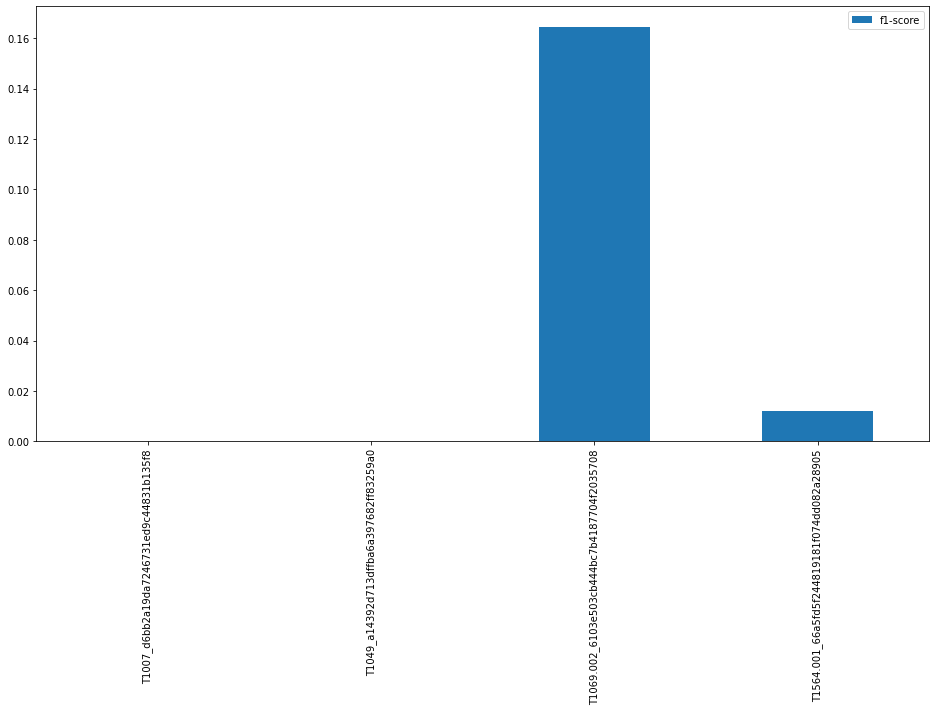

In [57]:
import matplotlib.pyplot as plt

# filtered_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize = (12,8))
filtered_report[['f1-score']].plot(kind='bar', figsize = (16,8))
plt.show()